
# Car Insurance Claims Prediction Model

This notebook builds, trains, and evaluates a multi-output neural network for predicting car insurance claims.

**Inputs:**
- ResNet image features
- Encoded & scaled structured data

**Outputs:**
- **Condition:** Binary classification (0: not claimable, 1: claimable)
- **Amount:** Regression (claim amount)

MLflow is used to track experiment parameters, metrics, and artifacts.


 ## Import Libraries and Load Processed Data

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import BinaryCrossentropy, LogCosh
from tensorflow.keras.metrics import AUC
from tensorflow.keras.regularizers import l2
import time
import os
import mlflow
import mlflow.tensorflow
import joblib

In [2]:
# Load processed data
data_path = r"C:\Users\varsh\OneDrive\Desktop\notebook\Fast_Furious_Insured\api\processed_data\final_dataOG.pkl"
data = joblib.load(data_path)

In [3]:
print(data.dtypes)
print(f"Data shape: {data.shape}")
print(data.head())

Image_path          object
Cost_of_vehicle    float64
Min_coverage       float64
Expiry_date        float64
Max_coverage       float64
                    ...   
2043               float32
2044               float32
2045               float32
2046               float32
2047               float32
Length: 2066, dtype: object
Data shape: (1310, 2066)
                            Image_path  Cost_of_vehicle  Min_coverage  \
0  images/train_images/img_4513976.jpg         0.453657      0.453657   
1  images/train_images/img_7764995.jpg         1.485276      1.485276   
2   images/train_images/img_451308.jpg         1.350717      1.350717   
3  images/train_images/img_7768372.jpg        -0.443403     -0.443403   
4  images/train_images/img_7765274.jpg        -1.104984     -1.104984   

   Expiry_date  Max_coverage  Condition    Amount  Insurance_company_A  \
0     0.694979      3.477133          0 -3.251022                  0.0   
1     0.036866      0.210875          1  0.541665              

## Preprocess Data

**Structured Data:** Drop unnecessary columns and extract values.

**Image Features:** Extract image feature columns.

**Labels:** Extract condition (binary) and amount (regression) labels.

In [4]:
# Structured Data: Drop first column and columns 5 & 6 (adjust as needed)
structured_data = data.iloc[:, :18].drop(columns=[data.columns[0], data.columns[5], data.columns[6]])
structured_data_scaled = structured_data.values
print(structured_data_scaled.shape)

(1310, 15)


In [5]:
# Image Features (assumes features start at column 18)
image_features = data.iloc[:, 18:].values

In [6]:
print("Structured data columns:", structured_data.columns.tolist())
print("All data columns:", data.columns.tolist())
print("Image features shape:", image_features.shape)

Structured data columns: ['Cost_of_vehicle', 'Min_coverage', 'Expiry_date', 'Max_coverage', 'Insurance_company_A', 'Insurance_company_AA', 'Insurance_company_AC', 'Insurance_company_B', 'Insurance_company_BB', 'Insurance_company_BC', 'Insurance_company_BQ', 'Insurance_company_C', 'Insurance_company_DA', 'Insurance_company_O', 'Insurance_company_RE']
All data columns: ['Image_path', 'Cost_of_vehicle', 'Min_coverage', 'Expiry_date', 'Max_coverage', 'Condition', 'Amount', 'Insurance_company_A', 'Insurance_company_AA', 'Insurance_company_AC', 'Insurance_company_B', 'Insurance_company_BB', 'Insurance_company_BC', 'Insurance_company_BQ', 'Insurance_company_C', 'Insurance_company_DA', 'Insurance_company_O', 'Insurance_company_RE', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 

In [7]:
# Extract labels
condition_labels = data['Condition'].values  # Binary classification target
amount_labels = data['Amount'].values.reshape(-1, 1)  # Regression target

In [8]:
# Check for NaNs before training
assert not np.any(pd.isna(condition_labels)), "Condition labels contain NaNs!"
assert not np.any(pd.isna(amount_labels)), "Amount labels contain NaNs!"


In [9]:
print("NaNs in image features:", np.isnan(image_features).sum())
print("NaNs in structured data:", np.isnan(structured_data_scaled).sum())

NaNs in image features: 0
NaNs in structured data: 0


## Build Model
Two-branch architecture:
- **Image Branch:** Processes image features.
- **Structured Data Branch:** Processes structured data.

The branches are concatenated and lead to two outputs:
- **condition_output:** Binary classification (sigmoid).
- **amount_output:** Regression (linear).

In [10]:
# Image Feature Branch
image_input = Input(shape=(image_features.shape[1],), name='image_input')
x = Dense(1024, kernel_initializer='he_normal', kernel_regularizer=l2(0.0005))(image_input)
x = BatchNormalization()(x)
x = LeakyReLU(negative_slope=0.1)(x)
x = Dropout(0.2)(x)

x = Dense(512, kernel_initializer='he_normal', kernel_regularizer=l2(0.0005))(x)
x = BatchNormalization()(x)
x = LeakyReLU(negative_slope=0.1)(x)
x = Dropout(0.2)(x)

# Structured Data Branch
structured_input = Input(shape=(structured_data_scaled.shape[1],), name='structured_input')
y = Dense(512, kernel_initializer='he_normal', kernel_regularizer=l2(0.0005))(structured_input)
y = BatchNormalization()(y)
y = LeakyReLU(negative_slope=0.1)(y)
y = Dropout(0.2)(y)

y = Dense(256, kernel_initializer='he_normal', kernel_regularizer=l2(0.0005))(y)
y = BatchNormalization()(y)
y = LeakyReLU(negative_slope=0.1)(y)
y = Dropout(0.2)(y)

# Concatenate the two branches
combined = Concatenate()([x, y])

# Shared Layers
z = Dense(256, kernel_initializer='he_normal', kernel_regularizer=l2(0.0005))(combined)
z = BatchNormalization()(z)
z = LeakyReLU(negative_slope=0.1)(z)
z = Dropout(0.1)(z)

# Condition Output (Binary Classification)
condition_z = Dense(128, kernel_initializer='he_normal', kernel_regularizer=l2(0.0005))(z)
condition_z = BatchNormalization()(condition_z)
condition_z = LeakyReLU(negative_slope=0.1)(condition_z)
condition_z = Dropout(0.1)(condition_z)

condition_output = Dense(1, activation='sigmoid', name='condition_output')(condition_z)

# Amount Output (Regression)
amount_z = Dense(256, kernel_initializer='he_normal', kernel_regularizer=l2(0.0005))(z)
amount_z = BatchNormalization()(amount_z)
amount_z = LeakyReLU(negative_slope=0.1)(amount_z)
amount_z = Dropout(0.1)(amount_z)

amount_output = Dense(1, activation='linear', name='amount_output')(amount_z)

# Define the Model
model = Model(inputs=[image_input, structured_input], outputs=[condition_output, amount_output])

# Adjust CosineDecay for Small Dataset
lr_schedule = CosineDecay(initial_learning_rate=0.001, decay_steps=2000, alpha=0.0001)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=lr_schedule, clipvalue=1.0),
    loss={'condition_output': 'binary_crossentropy', 'amount_output': tf.keras.losses.Huber(delta=3400)},
    metrics={'condition_output': AUC(), 'amount_output': 'mae'}
)

In [11]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)      │ (None, 2048)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ structured_input (InputLayer) │ (None, 15)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 1024)              │       2,098,176 │ image_input[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 512)               │           8,192 │ structured_input[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 1024)              │           4,096 │ dense[0][0]                │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 512)               │           2,048 │ dense_2[0][0]              │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu (LeakyReLU)       │ (None, 1024)              │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU)     │ (None, 512)               │               0 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 1024)              │               0 │ leaky_re_lu[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 512)               │               0 │ leaky_re_lu_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 512)               │         524,800 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 256)               │         131,328 │ dropout_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 512)               │           2,048 │ dense_1[0][0]              │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 256)               │           1,024 │ dense_3[0][0]              │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU)     │ (None, 512)               │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 3,070,210 (11.71 MB)

 Trainable params: 3,064,322 (11.69 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [12]:
# tuner = kt.BayesianOptimization(
#     build_model,
#     objective='val_loss',
#     max_trials=10,  # Number of models to try
#     executions_per_trial=1,
#     directory='tuner_results',
#     project_name='Fast_Furious_Insured'
# )

## Compute Sample Weights for Class Imbalance

Since the condition labels are imbalanced, we compute class weights and convert them to sample weights.

In [13]:
import collections
from sklearn.utils.class_weight import compute_class_weight

In [14]:
# Count class occurrences
condition_counts = collections.Counter(condition_labels)
total_samples = len(condition_labels)
for label, count in condition_counts.items():
    print(f"Class {label}: {count} samples ({(count/total_samples)*100:.2f}%)")

Class 0: 97 samples (7.40%)
Class 1: 1213 samples (92.60%)


In [15]:
# Compute class weights for condition labels
classes = np.array([0, 1])
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=condition_labels)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print("Computed Class Weights:", class_weight_dict)

Computed Class Weights: {0: np.float64(6.752577319587629), 1: np.float64(0.5399835119538334)}


In [16]:
# Convert class weights to sample weights for each sample
condition_sample_weights = np.array([class_weight_dict[label] for label in condition_labels], dtype=np.float32)
amount_sample_weights = np.ones_like(amount_labels, dtype=np.float32)  # Weight of 1 for regression output

In [17]:
# For later use, store sample weights in a dictionary (keyed by output names)
sample_weight_dict = {
    "condition_output": condition_sample_weights,
    "amount_output": amount_sample_weights
}

In [18]:
print("Condition sample weights shape:", sample_weight_dict["condition_output"].shape)
print("Amount sample weights shape:", sample_weight_dict["amount_output"].shape)

Condition sample weights shape: (1310,)
Amount sample weights shape: (1310, 1)


## Prepare Data for Training (Manual Train/Validation Split)

When using dictionaries for outputs and sample weights, manually splitting the data and using the `validation_data` argument ensures that the structures match.

In [19]:
from sklearn.model_selection import train_test_split

(train_image, val_image,
 train_structured, val_structured,
 train_condition, val_condition,
 train_amount, val_amount,
 train_sw_condition, val_sw_condition,
 train_sw_amount, val_sw_amount) = train_test_split(
    image_features,
    structured_data_scaled,
    condition_labels,
    amount_labels,
    sample_weight_dict["condition_output"],
    sample_weight_dict["amount_output"],
    test_size=0.2,
    random_state=42
)

In [20]:
# Convert targets and sample weights to lists in the order of model outputs
train_targets = [train_condition, train_amount]
val_targets   = [val_condition, val_amount]
train_sample_weights = [train_sw_condition, train_sw_amount]
val_sample_weights   = [val_sw_condition, val_sw_amount]

In [21]:
print("Training set shapes:")
print("Images:", train_image.shape, "Structured:", train_structured.shape)
print("Condition Labels:", np.array(train_condition).shape, "Amount Labels:", np.array(train_amount).shape)

Training set shapes:
Images: (1048, 2048) Structured: (1048, 15)
Condition Labels: (1048,) Amount Labels: (1048, 1)


In [22]:
# tuner.search(
#     [train_image, train_structured],
#     train_targets,
#     epochs=20, 
#     batch_size=32,  # You can also tune this
#     validation_data=([val_image, val_structured], val_targets),
#     callbacks=[EarlyStopping(monitor='val_loss', patience=3)]
# )

In [23]:
# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# print(f"""
# Best Hyperparameters:
# - Image Dense 1 Units: {best_hps.get('image_dense_1_units')}
# - Structured Dense 1 Units: {best_hps.get('structured_dense_1_units')}
# - Combined Dense 1 Units: {best_hps.get('combined_dense_1_units')}
# - L2 Regularization: {best_hps.get('l2_reg')}
# - Dropout Rate: {best_hps.get('dropout_rate')}
# - Learning Rate: {best_hps.get('learning_rate')}
# """)

# # Build the best model
# tuned_model = tuner.hypermodel.build(best_hps)

## Set Up Callbacks and MLflow Tracking

In [24]:
# Define model saving path and callbacks
model_dir = r"C:\Users\varsh\OneDrive\Desktop\notebook\Fast_Furious_Insured\api\models"
os.makedirs(model_dir, exist_ok=True)
best_model_path = os.path.join(model_dir, "best_model.keras")


In [25]:
checkpoint = ModelCheckpoint(best_model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [26]:
# Set up MLflow Tracking
#mlflow.set_tracking_uri("file:C:/Users/varsh/OneDrive/Desktop/notebook/Fast_Furious_Insured/python notebooks/mlruns")

In [27]:
# Set MLflow tracking URI if needed (uncomment and modify as necessary)
# mlflow.set_tracking_uri("your_tracking_uri")

## Train the Model with MLflow Tracking

The training run is wrapped inside an `mlflow.start_run()` block. Key parameters, metrics, and the best model artifact are logged.

In [28]:
with mlflow.start_run():
    # Log parameters
    mlflow.log_param('learning_rate', 0.001)
    mlflow.log_param('epochs', 50)
    mlflow.log_param('batch_size', 32)
    
    # Train the model
    history = model.fit(
        [train_image, train_structured],
        train_targets,
        epochs=100,
        batch_size=32,
        validation_data=(
            [val_image, val_structured],
            val_targets,
            val_sample_weights
        ),
        callbacks=[early_stopping, checkpoint],
        sample_weight=train_sample_weights,
        verbose=1
    )
    
    # Log metrics (for example, final validation loss)
    final_val_loss = history.history['val_loss'][-1]
    mlflow.log_metric('final_val_loss', final_val_loss)
    
    # Load the best model and save it as an artifact
    best_model = tf.keras.models.load_model(best_model_path)
    timestamp = int(time.time())
    final_model_path = os.path.join(model_dir, f"model_{timestamp}.keras")
    best_model.save(final_model_path, include_optimizer=True)
    mlflow.log_artifact(final_model_path)
    
    print(f"Best trained model saved at {final_model_path}")


Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - amount_output_loss: 0.5718 - amount_output_mae: 0.8165 - condition_output_auc: 0.9111 - condition_output_loss: 0.3070 - loss: 3.6180     
Epoch 1: val_loss improved from inf to 2.51708, saving model to C:\Users\varsh\OneDrive\Desktop\notebook\Fast_Furious_Insured\api\models\best_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 139ms/step - amount_output_loss: 0.5689 - amount_output_mae: 0.8141 - condition_output_auc: 0.9131 - condition_output_loss: 0.3037 - loss: 3.6074 - val_amount_output_loss: 0.1355 - val_amount_output_mae: 0.4287 - val_condition_output_auc: 1.0000 - val_condition_output_loss: 0.0414 - val_loss: 2.5171
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - amount_output_loss: 0.3245 - amount_output_mae: 0.6188 - condition_output_auc: 1.0000 - condition_output_loss: 0.0543 - loss: 2.6739 
Epoch 2: val_loss improved from 2.51708 to 2.34769, saving model to C:\Users\varsh\OneDrive\Desktop\notebook\Fast_Furious_Insured\api\

## Plot Training and Validation Loss

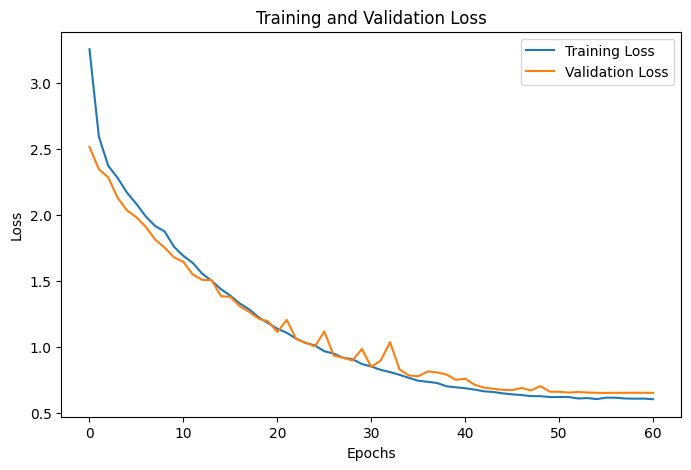

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Evaluate the Model

Evaluate both regression and classification performance.

In [30]:
# Load the best model if not already loaded
best_model = tf.keras.models.load_model(best_model_path)


In [31]:
# Predict on the full dataset
preds = best_model.predict([image_features, structured_data_scaled])
condition_preds_prob, amount_preds = preds[0], preds[1]
condition_preds = (condition_preds_prob > 0.5).astype(int)

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


In [32]:
# Regression Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report, confusion_matrix

mae = mean_absolute_error(amount_labels, amount_preds)
mse = mean_squared_error(amount_labels, amount_preds)
rmse = np.sqrt(mse)
r2 = r2_score(amount_labels, amount_preds)
print(f"Regression Metrics:\nMAE: {mae:.2f}, RMSE: {rmse:.2f}, R² Score: {r2:.4f}")

Regression Metrics:
MAE: 0.16, RMSE: 0.25, R² Score: 0.9382


In [33]:
# Classification Metrics
print("\nClassification Report:")
print(classification_report(condition_labels, condition_preds))
print("Confusion Matrix:")
print(confusion_matrix(condition_labels, condition_preds))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        97
           1       1.00      1.00      1.00      1213

    accuracy                           1.00      1310
   macro avg       1.00      1.00      1.00      1310
weighted avg       1.00      1.00      1.00      1310

Confusion Matrix:
[[  97    0]
 [   0 1213]]


## Save Model Metadata

In [34]:
import json

metadata = {best_model_path: min(history.history["val_loss"])}
metadata_path = os.path.join(os.path.dirname(best_model_path), "models_metadata.json")
with open(metadata_path, "w") as f:
    json.dump(metadata, f, indent=4)
print(f"Metadata file created with validation loss: {metadata[best_model_path]:.4f}")


Metadata file created with validation loss: 0.6518


## Residual Analysis and Plots

Calculate and visualize residuals for the regression task, and plot predicted vs. actual values for claimable cases.

In [35]:
# Residual Plot for Regression
residuals = amount_labels.flatten() - amount_preds.flatten()
print("Residuals shape:", residuals.shape)

Residuals shape: (1310,)


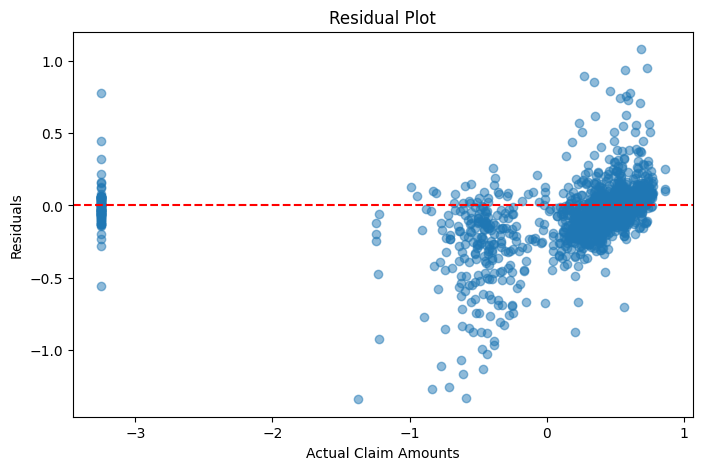

In [36]:
plt.figure(figsize=(8, 5))
plt.scatter(amount_labels.flatten(), residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Actual Claim Amounts")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()


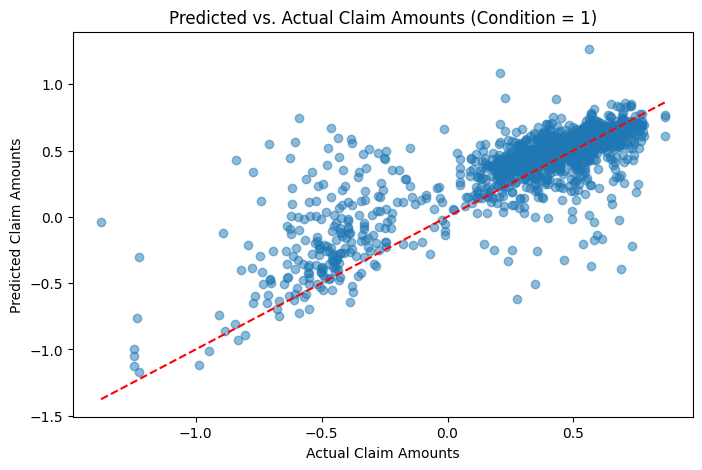

In [37]:
# Predicted vs Actual for claimable cases (Condition = 1)
idx = condition_labels == 1
true_claims = amount_labels[idx]
pred_claims = amount_preds[idx]

plt.figure(figsize=(8, 5))
plt.scatter(true_claims, pred_claims, alpha=0.5)
plt.plot([min(true_claims), max(true_claims)], [min(true_claims), max(true_claims)], 'r--')
plt.xlabel("Actual Claim Amounts")
plt.ylabel("Predicted Claim Amounts")
plt.title("Predicted vs. Actual Claim Amounts (Condition = 1)")
plt.show()

In [38]:
# Metrics for claimable cases
mae_claims = mean_absolute_error(true_claims, pred_claims)
rmse_claims = np.sqrt(mean_squared_error(true_claims, pred_claims))
r2_claims = r2_score(true_claims, pred_claims)
print(f"Claimable Cases Metrics:\nMAE: {mae_claims:.2f}, RMSE: {rmse_claims:.2f}, R²: {r2_claims:.4f}")

Claimable Cases Metrics:
MAE: 0.17, RMSE: 0.26, R²: 0.6100


## End of Notebook

This notebook demonstrated:
- Data loading and preprocessing
- Model building with two input branches and two outputs
- Handling class imbalance using sample weights
- Training with MLflow tracking (parameters, metrics, and artifacts)
- Evaluation and residual analysis

Adjust parameters, file paths, and MLflow tracking settings as needed.